In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math

# Set random seed for reproducibility
torch.manual_seed(42)

# 1. Example Input Text
input_text = "Language models learn to predict the next word in the sentence and they can do this job really well"
print(f"Input text: {input_text}\n")

# 2. Simple Tokenization
def simple_tokenizer(text):
    return text.lower().split()

tokens = simple_tokenizer(input_text)
print(f"Tokenized: {tokens}\n")

# Create  small vocabulary
vocab = ["<PAD>", "<UNK>"] + sorted(set(tokens))
token2idx = {token: idx for idx, token in enumerate(vocab)}
idx2token = {idx: token for idx, token in enumerate(vocab)}
vocab_size = len(vocab)

# Convert tokens to indices
token_indices = [token2idx[token] for token in tokens]
print(f"Token indices: {token_indices}\n")


Input text: Language models learn to predict the next word in the sentence and they can do this job really well

Tokenized: ['language', 'models', 'learn', 'to', 'predict', 'the', 'next', 'word', 'in', 'the', 'sentence', 'and', 'they', 'can', 'do', 'this', 'job', 'really', 'well']

Token indices: [7, 9, 8, 17, 11, 14, 10, 19, 5, 14, 13, 2, 15, 3, 4, 16, 6, 12, 18]



In [3]:
# 3. Token Embeddings
class Embedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)


In [4]:
# 4. Positional Encoding
def get_positional_encoding(max_seq_len, d_model):
    positional_encoding = np.zeros((max_seq_len, d_model))
    for pos in range(max_seq_len):
        for i in range(0, d_model, 2):
            positional_encoding[pos, i] = math.sin(pos / (10000 ** (i / d_model)))
            if i + 1 < d_model:
                positional_encoding[pos, i + 1] = math.cos(pos / (10000 ** (i / d_model)))

    return torch.FloatTensor(positional_encoding)


In [5]:
# 5. Self-Attention Mechanism
class SelfAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.q = nn.Linear(d_model, d_model)
        self.k = nn.Linear(d_model, d_model)
        self.v = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        # x shape: (batch_size, seq_len, d_model)
        batch_size, seq_len, _ = x.size()

        # Create Q, K, V projections
        q = self.q(x)  # (batch_size, seq_len, d_model)
        k = self.k(x)  # (batch_size, seq_len, d_model)
        v = self.v(x)  # (batch_size, seq_len, d_model)

        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_model)

        # Apply mask if provided (for causal/autoregressive attention)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Apply softmax to get attention weights
        attention_weights = torch.softmax(scores, dim=-1)

        # Apply attention weights to values
        output = torch.matmul(attention_weights, v)
        return output


In [6]:
# 6. Feed-Forward Network
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))


In [7]:
# 7. Basic Transformer Layer
class TransformerLayer(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.self_attention = SelfAttention(d_model)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # Self-attention with residual connection
        attn_output = self.self_attention(x, mask)
        x = self.norm1(x + attn_output)

        # Feed-forward with residual connection
        ff_output = self.feed_forward(x)
        x = self.norm2(x + ff_output)
        return x

In [8]:
# 8. Simple Language Model
class SimpleLM(nn.Module):
    def __init__(self, vocab_size, d_model, d_ff, num_layers, max_seq_len):
        super().__init__()
        self.d_model = d_model
        self.embedding = Embedding(vocab_size, d_model)
        self.pos_encoding = get_positional_encoding(max_seq_len, d_model)

        self.transformer_layers = nn.ModuleList([
            TransformerLayer(d_model, d_ff) for _ in range(num_layers)
        ])

        self.output_layer = nn.Linear(d_model, vocab_size)

    def generate_square_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, 0.0).masked_fill(mask == 1, 1.0)
        return mask

    def forward(self, x):
        # x shape= (batch_size, seq_len)
        seq_len = x.size(1)
        # Create causal mask
        mask = self.generate_square_mask(seq_len).to(x.device)
        # Get embeddings
        x = self.embedding(x)
        # Add positional encodings
        x = x + self.pos_encoding[:seq_len, :].unsqueeze(0).to(x.device)
        # Pass through transformer layers
        for layer in self.transformer_layers:
            x = layer(x, mask)
        # Project to vocabulary
        output = self.output_layer(x)
        return output


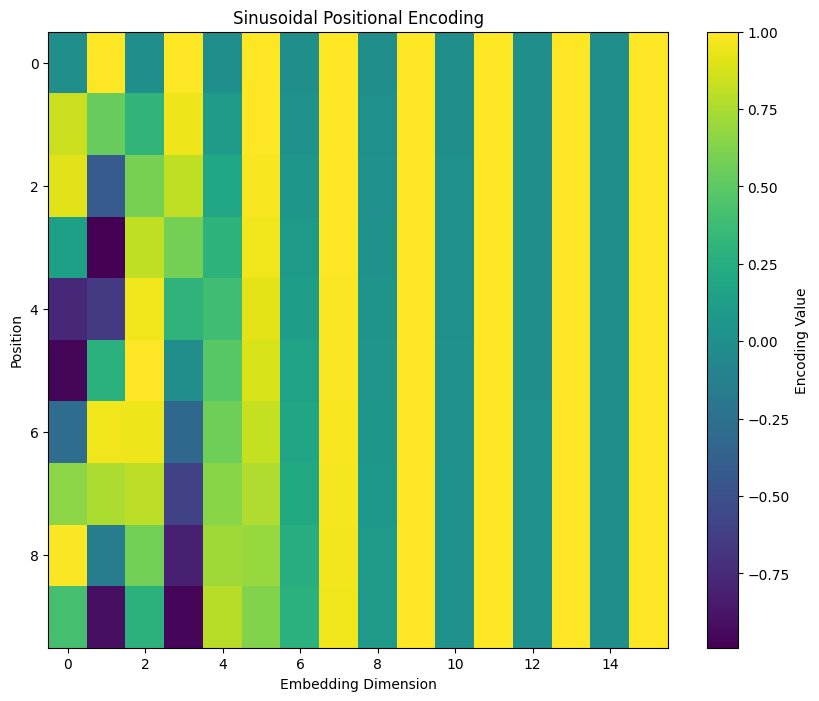

In [9]:
# Set model parameters
d_model = 16    # Embedding dimension
d_ff = 32       # Feed-forward dimension
num_layers = 2  # Number of transformer layers
max_seq_len = 20  # Maximum sequence length

# Training data
training_sentences = [
    "language models learn to predict the next word",
    "transformer models process all tokens at once",
    "attention mechanisms help models focus on relevant context",
    "large language models require extensive training data",
    "the model learns to predict the next word in sequence"
]

# Prepare training data
all_tokens = []
for sentence in training_sentences:
    all_tokens.extend(simple_tokenizer(sentence))

# Update vocabulary
vocab = ["<PAD>", "<UNK>"] + sorted(set(all_tokens))
token2idx = {token: idx for idx, token in enumerate(vocab)}
idx2token = {idx: token for idx, token in enumerate(vocab)}
vocab_size = len(vocab)

# Create the model with updated vocabulary
model = SimpleLM(vocab_size, d_model, d_ff, num_layers, max_seq_len)

# Visualize Positional Encoding function
def visualize_positional_encoding(pos_encoding):
    plt.figure(figsize=(10, 8))
    plt.imshow(pos_encoding.numpy(), cmap='viridis', aspect='auto')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Position')
    plt.colorbar(label='Encoding Value')
    plt.title('Sinusoidal Positional Encoding')
    plt.show()

# Visualize positional encoding
pos_encoding = model.pos_encoding[:10]  # First 10 positions
visualize_positional_encoding(pos_encoding)

In [10]:
# Training parameters
learning_rate = 0.01
num_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# Prepare input-target pairs
training_examples = []
for sentence in training_sentences:
    tokens = simple_tokenizer(sentence)
    indices = [token2idx.get(t, token2idx["<UNK>"]) for t in tokens]

    # For each position, predict the next token
    for i in range(len(indices)-1):
        input_seq = indices[:i+1]
        target = indices[i+1]
        training_examples.append((input_seq, target))

print(f"Number of training examples: {len(training_examples)}")

# Training loop
losses = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for input_seq, target in training_examples:
        # Pad sequence to handle variable lengths
        padded_input = input_seq + [token2idx["<PAD>"]] * (max_seq_len - len(input_seq))
        padded_input = padded_input[:max_seq_len]  # Truncate if too long

        # Convert to tensors
        input_tensor = torch.tensor([padded_input])
        target_tensor = torch.tensor([target])

        # Forward pass
        output = model(input_tensor)
        logits = output[0, len(input_seq)-1, :]  # Get logits for the last actual token

        # Compute loss and update weights
        loss = loss_fn(logits.unsqueeze(0), target_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    losses.append(epoch_loss / len(training_examples))

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {losses[-1]:.4f}")

Number of training examples: 35
Epoch 10/100, Loss: 0.3474
Epoch 20/100, Loss: 0.0285
Epoch 30/100, Loss: 0.7016
Epoch 40/100, Loss: 0.9370
Epoch 50/100, Loss: 0.0866
Epoch 60/100, Loss: 0.0072
Epoch 70/100, Loss: 0.0040
Epoch 80/100, Loss: 0.0026
Epoch 90/100, Loss: 0.0019
Epoch 100/100, Loss: 0.0014


In [11]:
# example
test_sentence = "attention mechanisms help models"
test_tokens = simple_tokenizer(test_sentence)
test_indices = [token2idx.get(t, token2idx["<UNK>"]) for t in test_tokens]

# Pad and convert to tensor
padded_test = test_indices + [token2idx["<PAD>"]] * (max_seq_len - len(test_indices))
padded_test = padded_test[:max_seq_len]
test_tensor = torch.tensor([padded_test])

# Generate prediction
with torch.no_grad():
    output = model(test_tensor)
    last_token_logits = output[0, len(test_indices)-1, :]

    # Get top 3 predictions
    top_indices = torch.topk(last_token_logits, 3).indices.tolist()
    top_predictions = [idx2token[idx] for idx in top_indices]

print(f"Input: '{test_sentence}'")
print(f"Top 3 predictions for next word: {top_predictions}")

Input: 'attention mechanisms help models'
Top 3 predictions for next word: ['focus', 'require', 'sequence']
